In [34]:
import numpy as np
import matplotlib.pyplot as plt

In [35]:
# Read out data from "sn.dat" to array "SN_arr"
sn_dat = open("sn.dat", 'r')

SN = sn_dat.readlines()

sn_dat.close()

SN_arr = np.zeros((2, 16))

i = 0

for line in SN:
    string = line
    _, JD, Mag, dMag = line.split()
    if JD == "JD":
        continue
    SN_arr[0][i] = JD; SN_arr[1][i] = Mag
    i += 1
    
    cnt = (SN_arr[0][15] - SN_arr[0][0]) / 101

In [36]:
#data is array with arr[x & y][num of data] : arr[0][] = x, arr[1][] = y
def Lagrange_interpolation(data, x):
    y = 0
    
    for i in range(len(data[0])):
        up = 1; down = 1
        for j in range(len(data[0])):
            if i == j:
                continue
            up *= (x - data[0][j])
            down *= (data[0][i] - data[0][j])
        y += (data[1][i] * up / down)
    
    return y

In [37]:
# Create data with Lagrange interpolation
result_lag = np.zeros((2, 102))

x0 = SN_arr[0][0]
result_lag[0][101] = SN_arr[0][15]
result_lag[1][101] = SN_arr[1][15]

for _ in range(0, 101):
    result_lag[0][_] = x0
    result_lag[1][_] = Lagrange_interpolation(SN_arr, x0)
    x0 += cnt

C:\Users\AGN\AppData\Local\Temp\ipykernel_1920\215152268.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


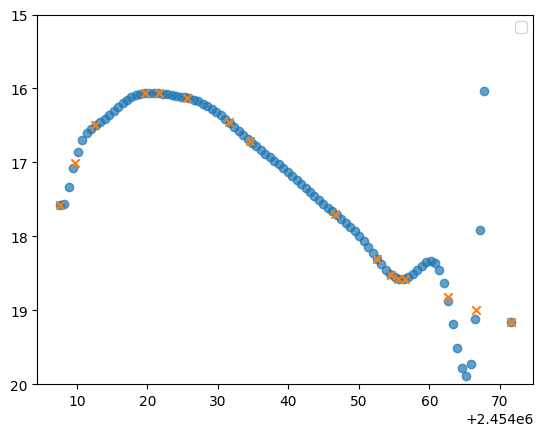

In [38]:
# Plotting results by Lagrange interpolation
plt.figure()
plt.ylim(15, 20)
plt.gca().invert_yaxis()
plt.scatter(result_lag[0], result_lag[1], marker='o', alpha=0.7)
plt.scatter(SN_arr[0], SN_arr[1], marker='x')
plt.legend()


In [39]:
# definition of Neville's Algorithm for interpolation
# x is position to do interpolation
# data is 2D array [x & y][num of datas] with "sn.dat"
# n is # of points to use
# sp is start point of interpolation
# 재귀함수로 구현됨.

def Neville_algorithm(data, x, start, end):
    if (end - start) == 0:
        return data[1][start]
    
    return ((x - data[0][end])*(Neville_algorithm(data, x, start, end - 1)) 
            + ((data[0][start] - x) * Neville_algorithm(data, x, start + 1, end))) / (data[0][start] - data[0][end])

In [40]:
result_nev = np.zeros((4, 2, 101))

In [41]:
adder = [2, 4, 6, 15]

for n in range(4):
    cur = 0
    x0 = SN_arr[0][0]
    for _ in range(len(result_nev[n][0])):
        if ((cur + adder[n] < 15) and (SN_arr[0][cur + 1] < x0)): # Move intepolation position bin by bin. At the endpoint, don't change current position. (ex. cur == 14)
            cur += 1
        result_nev[n][0][_] = x0
        result_nev[n][1][_] = Neville_algorithm(SN_arr, x0, cur, cur+adder[n])
        x0 += cnt
    

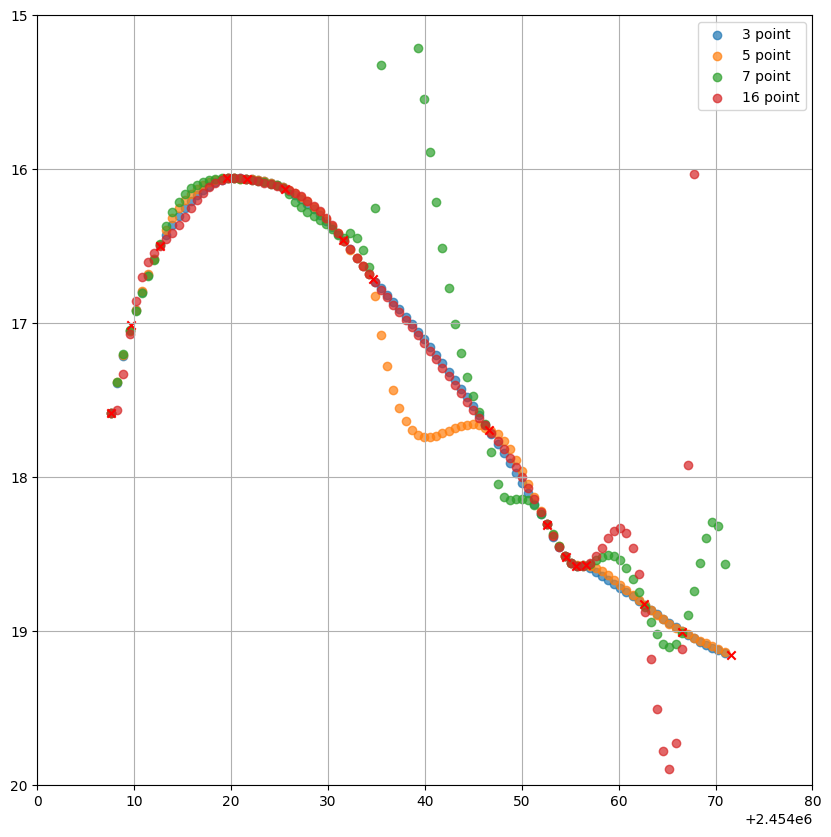

In [42]:
# Plotting results by Lagrange interpolation
label = ['3 point', '5 point', '7 point', '16 point']
plt.figure(figsize=(10, 10))
plt.ylim(15, 20)
plt.xlim(2.454*10**6, 2.45408*10**6)
plt.grid()
plt.gca().invert_yaxis()
for _ in range(4):
    plt.scatter(result_nev[_][0], result_nev[_][1], marker='o', alpha=0.7, label=label[_])
plt.scatter(SN_arr[0], SN_arr[1], marker='x', color='red')
plt.legend()

In [43]:
#Gaussian noise 가내수공업
noise = np.random.normal(0, 0.1, size=16)
print(noise)

[-0.01446499  0.1265752  -0.10029264 -0.02819137  0.13213531  0.03685116
 -0.10131404  0.05544954 -0.04091617  0.01860567  0.0512663  -0.05078864
 -0.01078688  0.0683443   0.0068356  -0.03889152]


In [44]:
# Check out when data has noise.
# use Gaussian noise from above. set as "noise" with 1D, 16 float array
SN_arr_noise = np.zeros((2, 16))
SN_arr_noise += SN_arr
SN_arr_noise[1] += noise

#define array type data to save results of calculation
result_nev_noise = np.zeros((4, 2, 101))

In [48]:
adder_noise = [2, 4, 6, 15]

for k in range(4):
    x0 = SN_arr_noise[0][0]
    cur = 0
    for _ in range(len(result_nev_noise[k][0])):
        if ((cur + adder_noise[k] < 15) and (SN_arr_noise[0][cur + 1] < x0)):
            cur += 1
        result_nev_noise[k][0][_] = x0
        result_nev_noise[k][1][_] = Neville_algorithm(SN_arr_noise, x0, cur, cur+adder_noise[k])
        x0 += cnt    

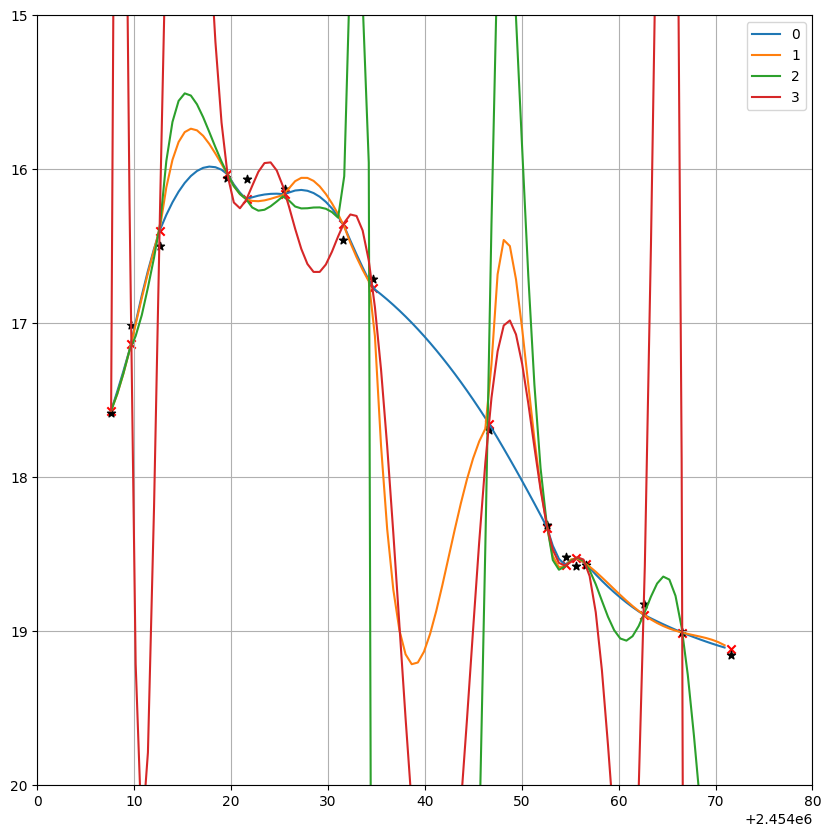

In [49]:
plt.figure(figsize=(10, 10))
plt.grid(visible=True)
plt.ylim(15, 20)
plt.xlim(2.454*10**6, 2.45408*10**6)
plt.gca().invert_yaxis()
for _ in range(4):
    plt.plot(result_nev_noise[_][0], result_nev_noise[_][1], label=_)
plt.scatter(SN_arr_noise[0], SN_arr_noise[1], marker='x', color='red')
plt.scatter(SN_arr[0], SN_arr[1], marker='*', color='black')
plt.legend()

As a result, the less usage of data for interpolation gave more precise result with smooth graph.
More and more data used for interpolation, they gave much overfitted results.

In [47]:
MSE = np.zeros(4)

for k in range(4):
    MSE[k] = np.mean(np.square(result_nev_noise[k][1] - result_nev[k][1]))
    
print(MSE)

[4.83030523e-03 2.84759686e-01 3.58512137e+02 7.33418275e+02]
